In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle

In [2]:
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']

# RTS index

## Reading files

In [6]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [7]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

## Setting parameters & data

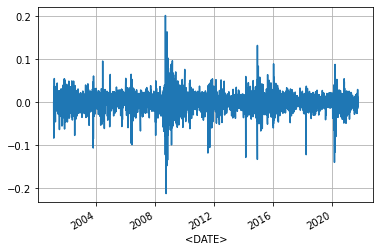

In [8]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [9]:
rescale_factor = 100
start_date = '2014-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [10]:
n = input_data.shape[0]

In [11]:
n

1964

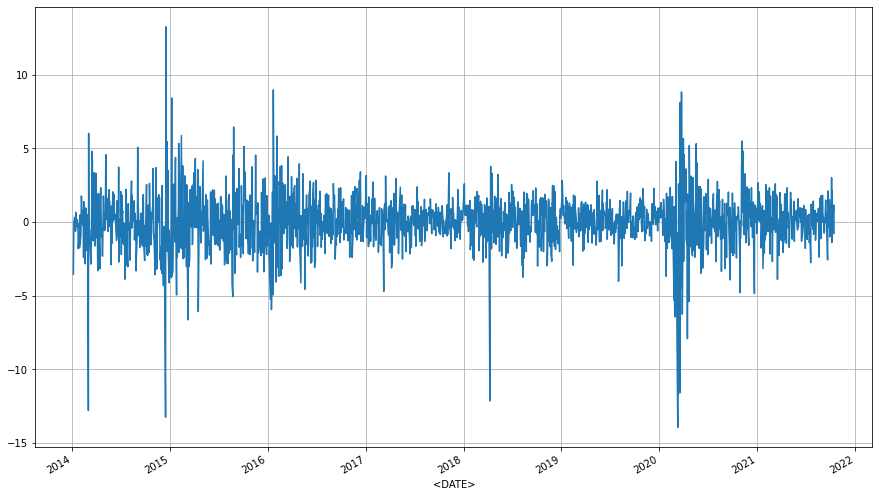

In [12]:
input_data.plot(figsize=(15, 9))

plt.grid()
plt.show()

In [13]:
input_data.describe()

count    1964.000000
mean        0.013812
std         1.826568
min       -13.948614
25%        -0.899103
50%         0.071543
75%         0.935148
max        13.246192
Name: log return, dtype: float64

In [14]:
days_of_week = pd.Series(input_data.index.dayofweek, index=input_data.index, name='day of week').copy()

### train & test split 

In [15]:
input_data.shape

(1964,)

In [15]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [17]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

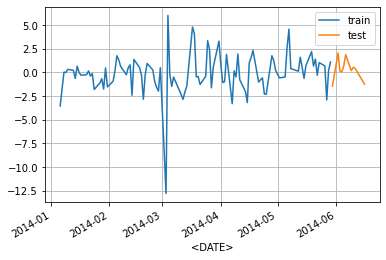

In [18]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [19]:
train.describe()

count    100.000000
mean      -0.092526
std        2.163714
min      -12.795677
25%       -0.982087
50%       -0.067699
75%        0.787302
max        6.017611
Name: log return, dtype: float64

### Setting consequent meta parameters

In [20]:
# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

In [21]:
train_sample_std

2.163714165933207

In [22]:
first_h

array([4.68165899])

#### Using classic GARCH to get initial parameters values

In [23]:
garch_mean = 'Zero'
garch_dist = 'normal'

garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 224.92398317397047
Iteration:      2,   Func. Count:     13,   Neg. LLF: 219.79943267590863
Iteration:      3,   Func. Count:     18,   Neg. LLF: 217.77485889463415
Iteration:      4,   Func. Count:     23,   Neg. LLF: 217.26693911801357
Iteration:      5,   Func. Count:     27,   Neg. LLF: 217.43521932030816
Iteration:      6,   Func. Count:     32,   Neg. LLF: 217.2291730585139
Iteration:      7,   Func. Count:     36,   Neg. LLF: 217.22478250215488
Iteration:      8,   Func. Count:     40,   Neg. LLF: 217.22476113198286
Iteration:      9,   Func. Count:     43,   Neg. LLF: 217.22476113228768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 217.22476113198286
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9


In [24]:
garch_fitted.params

omega       2.430453e-01
alpha[1]    1.627996e-11
beta[1]     9.533994e-01
Name: params, dtype: float64

In [25]:
alpha_0_ini_vanilla = garch_fitted.params.iloc[0]
alpha_ini_vanilla = garch_fitted.params.iloc[1:(q + 1)].values
beta_ini_vanilla = garch_fitted.params.iloc[(q + 1):].values

In [26]:
consequent_params_ini_vanilla = {'alpha_0': alpha_0_ini_vanilla, 'alpha': alpha_ini_vanilla, 'beta': beta_ini_vanilla}

#### Setting dict w/ all consequent meta parameters

In [27]:
consequent_parameters = {'p': p, 'q': q, 'first_h': first_h}

##### `parameters_ini` and `bounds` not yet set!

## Modeling

### 2 clusters

#### setting clusterization (antecedent) parameters

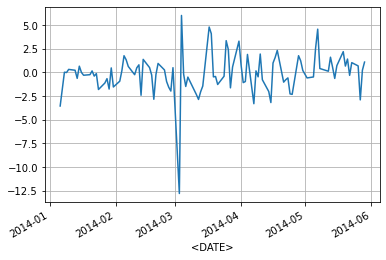

In [28]:
train.plot()

plt.grid()
plt.show()

In [29]:
clusterization_method = 'gaussian'

n_clusters = 4

centers = [-10, -2, 3, 7.5]
variances = [4, 4, 4, 4]

clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': n_clusters}

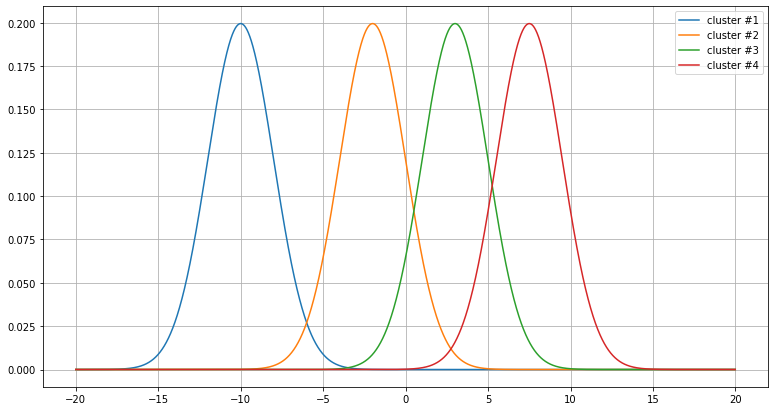

In [30]:
plt.figure(figsize=(13, 7))

for i in range(n_clusters):
    _range = np.arange(-20, 20, .01)
    _data = sts.norm(centers[i], variances[i] ** .5).pdf(_range)
    
    plt.plot(_range, _data, label=f'cluster #{i + 1}')
   
plt.legend()
plt.grid()
plt.show()

#### setting `parameters_ini` in consequent

In [31]:
alpha_0_ini = np.array([alpha_0_ini_vanilla] * n_clusters)
alpha_ini = np.array([alpha_ini_vanilla] * n_clusters).T
beta_ini = np.array([beta_ini_vanilla] * n_clusters).T

parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

consequent_parameters['parameters_ini'] = parameters_ini

In [32]:
parameters_ini

{'alpha_0': array([0.24304534, 0.24304534, 0.24304534, 0.24304534]),
 'alpha': array([[1.62799605e-11, 1.62799605e-11, 1.62799605e-11, 1.62799605e-11]]),
 'beta': array([[0.95339937, 0.95339937, 0.95339937, 0.95339937]])}

#### setting consequent parameters constraints (passed to LS)

In [33]:
lower_bounds = [0] * ((1 + p + q) * n_clusters)
upper_bounds = [+np.inf] * n_clusters + [1] * ((p + q) * n_clusters)
bounds = (lower_bounds, upper_bounds)

consequent_parameters['bounds'] = bounds

#### creating model instance

In [34]:
# logging.basicConfig(level=logging.DEBUG)

In [35]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=consequent_parameters,
                           data_to_cluster='train')

##### fitting

In [36]:
%%time

fvm.fit()

CPU times: user 15.8 s, sys: 233 ms, total: 16.1 s
Wall time: 12 s


##### testing

In [37]:
# n_test = 20

# test = test.iloc[:n_test].copy()
# input_cut = pd.concat([train, test]).copy()

# data_to_cluster_test = data_to_cluster_test.iloc[:n_test].copy()

In [38]:
test.shape

(10,)

In [50]:
%%time

fvm.feed_daily_data(test, data_to_cluster=None)

CPU times: user 3min 7s, sys: 1.49 s, total: 3min 8s
Wall time: 2min 40s


#### dumping

In [51]:
cur_time = pd.Timestamp.today()
print(cur_time)
with open(f'{research_results_folder}/fvm_{cur_time}.pkl', 'wb') as file:
    pickle.dump(fvm, file)

2022-01-29 12:53:34.942674


#### smth

In [52]:
len(fvm._hist_output)

16

In [53]:
fvm.hist_output.shape

(10,)

In [54]:
# (fvm.rules_outputs_hist[0] == fvm.rules_outputs_hist[1]).all()

In [55]:
fvm.clusters_parameters_hist

,centers,variances,n_clusters
<DATE>,,,
2014-05-30,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-02,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-03,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-04,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-05,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-06,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-09,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-10,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2014-06-11,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4


#### Plots

In [56]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [57]:
simple_garch_forecasts

array([5.19594901, 5.19685985, 5.19772825, 5.19855618, 5.19934552,
       5.20009808, 5.20081557, 5.20149963, 5.20215181, 5.20277359])

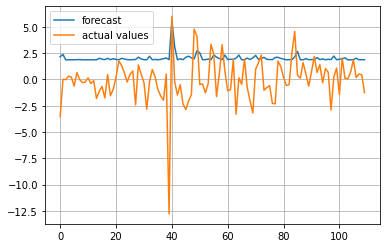

In [58]:
plt.plot(fvm.h[:-1] ** .5, label='forecast')
plt.plot(input_cut.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

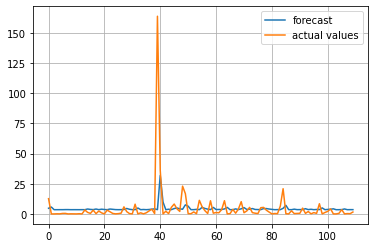

In [59]:
plt.plot(fvm.h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

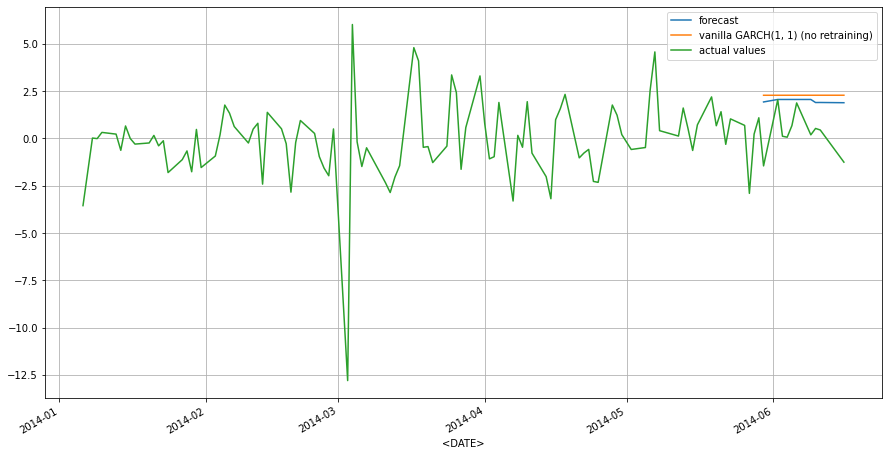

In [60]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

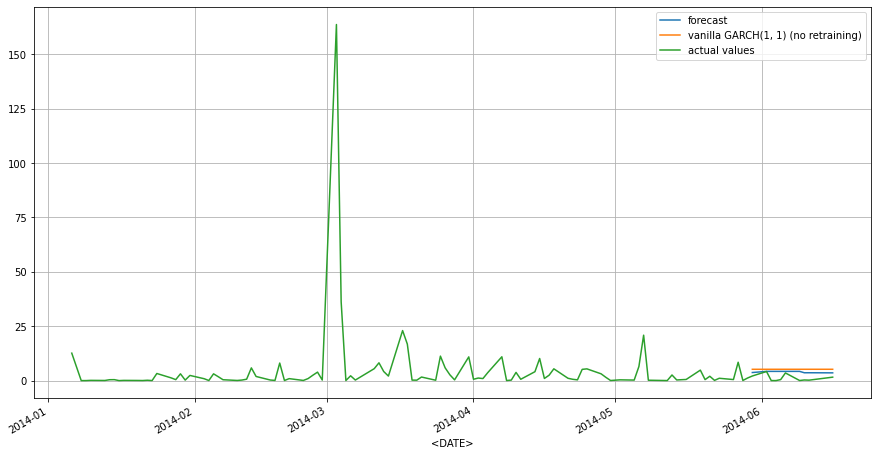

In [61]:
fvm.hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

#### Errors

##### my model

In [62]:
mean_squared_error(fvm.hist_output, test ** 2, squared=True)

9.716895316554604275

In [63]:
mean_squared_error(fvm.hist_output, test ** 2, squared=False)

3.1171935000180217036

In [64]:
mean_absolute_percentage_error(fvm.hist_output, test ** 2)

0.69180243080433159486

##### GARCH (no retraining)

In [65]:
mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)

17.889308983968967

In [66]:
mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)

4.229575508720582

In [67]:
mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

0.7621674233863559

# Fitting antecedent parameters

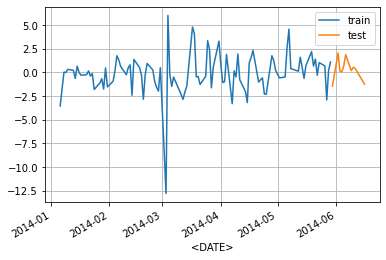

In [70]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [71]:
clusterization_method = 'gaussian'
antecedent_params_set = []

In [72]:
# new params
n_clusters = 4

centers = [-10, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-8, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-12, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-10, -2, 3, 9.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# # new params
# n_clusters = 4

# centers = [-8, -2, 3, 9.5]
# variances = [4, 4, 4, 4]

# antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# # new params
# n_clusters = 4

# centers = [-12, -2, 3, 9.5]
# variances = [4, 4, 4, 4]

# antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# # new params
# n_clusters = 4

# centers = [-10, -2, 3, 5.5]
# variances = [4, 4, 4, 4]

# antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# # new params
# n_clusters = 4

# centers = [-8, -2, 3, 5.5]
# variances = [4, 4, 4, 4]

# antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# # new params
# n_clusters = 4

# centers = [-12, -2, 3, 5.5]
# variances = [4, 4, 4, 4]

# antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

In [73]:
result = None

In [74]:
logging.basicConfig(level=logging.INFO)

In [76]:
%%time

result = fit_antecedent_params(train, test,
                               consequent_metaparams=consequent_parameters,
                               consequent_params_ini=consequent_params_ini_vanilla,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train='train', data_to_cluster_test=None)

INFO:fit_antecedent_params:Starting iteration #0
INFO:model.model:Creating an instance of FuzzyVolatilityModel
INFO:fit_antecedent_params:Iteration #0 ended
INFO:fit_antecedent_params:Starting iteration #1
INFO:model.model:Creating an instance of FuzzyVolatilityModel
INFO:fit_antecedent_params:Iteration #1 ended
INFO:fit_antecedent_params:Starting iteration #2
INFO:model.model:Creating an instance of FuzzyVolatilityModel
INFO:fit_antecedent_params:Iteration #2 ended
INFO:fit_antecedent_params:Starting iteration #3
INFO:model.model:Creating an instance of FuzzyVolatilityModel
INFO:fit_antecedent_params:Iteration #3 ended


CPU times: user 14min 39s, sys: 5.44 s, total: 14min 45s
Wall time: 12min 44s


## Adding some info

In [77]:
result['train'] = train
result['test'] = test
result['antecedent_params_set'] = antecedent_params_set

## Dumping

In [78]:
cur_time = pd.Timestamp.today()
print(cur_time)

with open(f'{research_results_folder}/fitting_consequent_params_result_{cur_time}.pkl', 'wb') as file:
    pickle.dump(result, file)

2022-01-29 13:07:36.494564


## Looking at results

In [79]:
result

{'fvms': [<model.FuzzyVolatilityModel at 0x2abd23e73610>,
 'mses': [10.175789472144835948,
  10.175789472144835948,
  10.175789472144835948,
  10.175789472144835948],
 'mapes': [0.6942332603336166151,
  0.6942332603336166151,
  0.6942332603336166151,
  0.6942332603336166151],
 'train': <DATE>
 2014-01-06   -3.552256
 2014-01-08    0.018679
 2014-01-09   -0.010776
 2014-01-10    0.317039
 2014-01-13    0.226762
                 ...   
 2014-05-23    1.031246
 2014-05-26    0.687376
 2014-05-27   -2.903862
 2014-05-28    0.227871
 2014-05-29    1.089806
 Name: log return, Length: 100, dtype: float64,
 'test': <DATE>
 2014-05-30   -1.452643
 2014-06-02    2.044933
 2014-06-03    0.114111
 2014-06-04    0.063423
 2014-06-05    0.676265
 2014-06-06    1.874572
 2014-06-09    0.187448
 2014-06-10    0.526647
 2014-06-11    0.444643
 2014-06-16   -1.254435
 Name: log return, dtype: float64,
 'antecedent_params_set': [{'centers': [-10, -2, 3, 7.5],
   'variances': [4, 4, 4, 4],
   'n_clusters'

In [80]:
fvms = result['fvms']

In [81]:
result['mses']

[10.175789472144835948,
 10.175789472144835948,
 10.175789472144835948,
 10.175789472144835948]

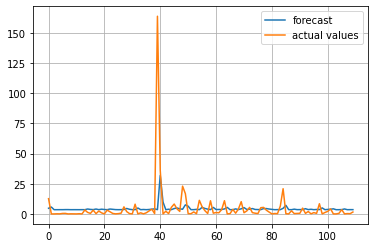

In [82]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

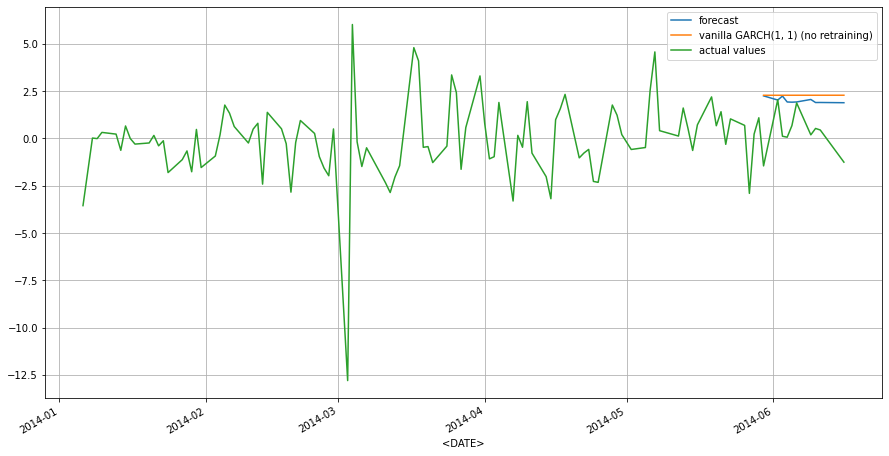

In [83]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

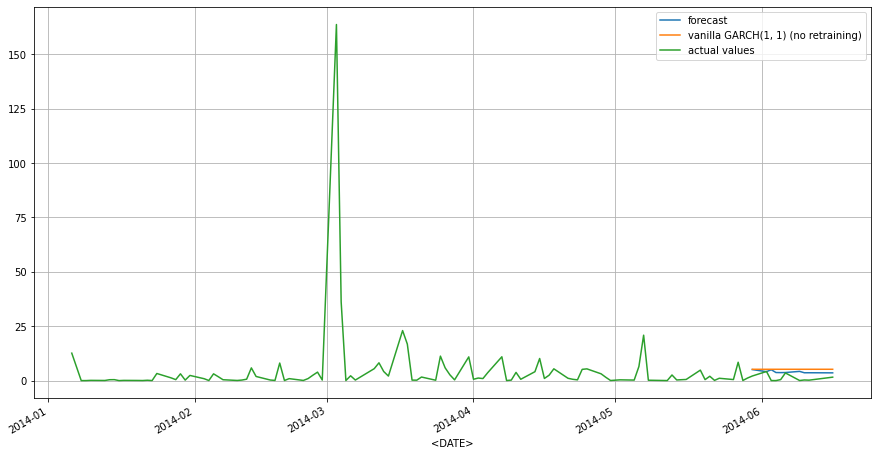

In [84]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()